### data processing

In [33]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('titanic.csv')
df = df.drop(columns = 'Name' )
df = df.drop(columns = 'Cabin' )

mask = df['Ticket'].str.contains('[a-zA-Z]')
df = df[~mask]
df = df.dropna()

def encode_categorical(df):
    label_encoder = LabelEncoder()
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = label_encoder.fit_transform(df[column])
        elif df[column].dtype == 'float64' or df[column].dtype == 'int64':
            df[column] = df[column].fillna(df[column].mean())
    return df
df = encode_categorical(df)




### dataset building

In [34]:
from sklearn.model_selection import train_test_split
import torch.utils.data as Data
import torch

batch_sizes = 32

x = df.iloc[:,2:]
y = df.iloc[:,1:2]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2004)

x_train_tensor = torch.FloatTensor(x_train.values)
y_train_tensor = torch.FloatTensor(y_train.values)
x_test_tensor = torch.FloatTensor(x_test.values)
y_test_tensor = torch.FloatTensor(y_test.values)

train_dataset = Data.TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = Data.TensorDataset(x_test_tensor, y_test_tensor)

train_dataloader = Data.DataLoader(train_dataset,batch_sizes,shuffle=True)
test_dataloader = Data.DataLoader(test_dataset,batch_sizes,shuffle=True)

### model building

In [35]:
import torch.nn as nn

class LinearNet(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear_1 = nn.Linear(in_features, 64)  
        self.linear_2 = nn.Linear(64, 16)
        self.linear_3 = nn.Linear(16, out_features)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        y = self.linear_1(x)
        y = self.linear_2(y)
        y = self.linear_3(y)
        y = self.sigmoid(y)
        return y

### parameters determination

In [48]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LinearNet(8,1).to(device)
loss = nn.BCELoss()
optimizer = optim.Adam(model.parameters(),lr=1e-3)

### model training

In [49]:

def train_model(model,dataloader):
    model.train()
    
    total_loss = 0
    for idx,(x,y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        cur_loss = loss(y_pred,y)
        optimizer.zero_grad()
        cur_loss.backward()
        optimizer.step()
        
        total_loss += cur_loss.item()
    print(f"train loss:{total_loss/len(train_dataset)}")
    return total_loss

### model testing

In [50]:

def test_model(model, dataloader):
    model.eval()

    total_loss = 0.
    for idx, (x, y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        cur_loss = loss(y_pred, y)
        total_loss += cur_loss.item()
        
    print(f"Test loss: {total_loss/len(test_dataset)}")
    return total_loss

### model evaluation

==== Epoch 0 ====
train loss:0.0839090212281928
Test loss: 0.0777091051523502
==== Epoch 1 ====
train loss:0.0538678670504007
Test loss: 0.06158675138766949
==== Epoch 2 ====
train loss:0.040028940841376065
Test loss: 0.02873884657254586
==== Epoch 3 ====
train loss:0.02398383387600083
Test loss: 0.027089142455504492
==== Epoch 4 ====
train loss:0.019351374313055753
Test loss: 0.022939858528283927
==== Epoch 5 ====
train loss:0.01837289290255811
Test loss: 0.022385837366947763
==== Epoch 6 ====
train loss:0.018233017102781548
Test loss: 0.02325790461439353
==== Epoch 7 ====
train loss:0.019950029792555845
Test loss: 0.034698850833452664
==== Epoch 8 ====
train loss:0.02365740939795253
Test loss: 0.021296315754835423
==== Epoch 9 ====
train loss:0.019894050690064946
Test loss: 0.0286856465614759
==== Epoch 10 ====
train loss:0.02041222819362778
Test loss: 0.023640837233800154
==== Epoch 11 ====
train loss:0.01853229094700641
Test loss: 0.022151783108711243
==== Epoch 12 ====
train loss:

<function matplotlib.pyplot.show(close=None, block=None)>

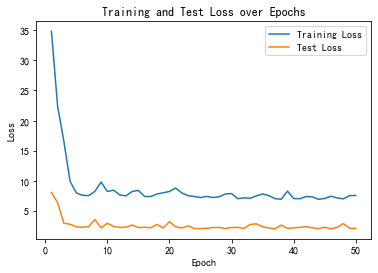

In [51]:
import matplotlib.pyplot as plt

num_epoch = 50
train_losses = []
test_losses = []

for i in range(num_epoch):
    print(f"==== Epoch {i} ====")
    train_loss = train_model(model, train_dataloader)
    test_loss = test_model(model, test_dataloader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)



plt.plot(range(1, num_epoch + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epoch + 1), test_losses, label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()

plt.show